In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

In [15]:
baseline_data = pd.read_csv("/Users/seonminkim/Documents/DATASCI217/08-time-stats-and-ml-EstherKim97/patient_baseline.csv", sep = "\t")
longitudinal_data = pd.read_csv("/Users/seonminkim/Documents/DATASCI217/08-time-stats-and-ml-EstherKim97/patient_longitudinal.csv", sep = "\t")
treatment_data = pd.read_csv("/Users/seonminkim/Documents/DATASCI217/08-time-stats-and-ml-EstherKim97/patient_treatment.csv", sep = "\t")

# Time Series Tasks

### 1. Convert the longitudinal blood pressure measurements into a proper time series

In [16]:
# Convert the visit_date variable into proper time series
longitudinal_data["visit_date"] = pd.to_datetime(longitudinal_data["visit_date"], format="%Y-%m-%d")

In [17]:
# Identifying Missing values - no missing values found
longitudinal_data["visit_date"].isna().sum()
longitudinal_data["visit_date"] = longitudinal_data["visit_date"].fillna(method="bfill")

# Identifying Duplicates - Duplicates are aggregated.
longitudinal_data["visit_date"].duplicated().sum()

longitudinal_data_datetime = longitudinal_data.groupby("visit_date").aggregate({"bp_systolic": "mean"})

# Localize timezones to UTC
longitudinal_data_datetime = longitudinal_data_datetime.tz_localize("UTC")

/var/folders/t8/4nh9lkn90_j8336dnbb9r13w0000gn/T/ipykernel_25181/470696795.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  longitudinal_data["visit_date"] = longitudinal_data["visit_date"].fillna(method="bfill")


### 2. Analyze blood pressure trends

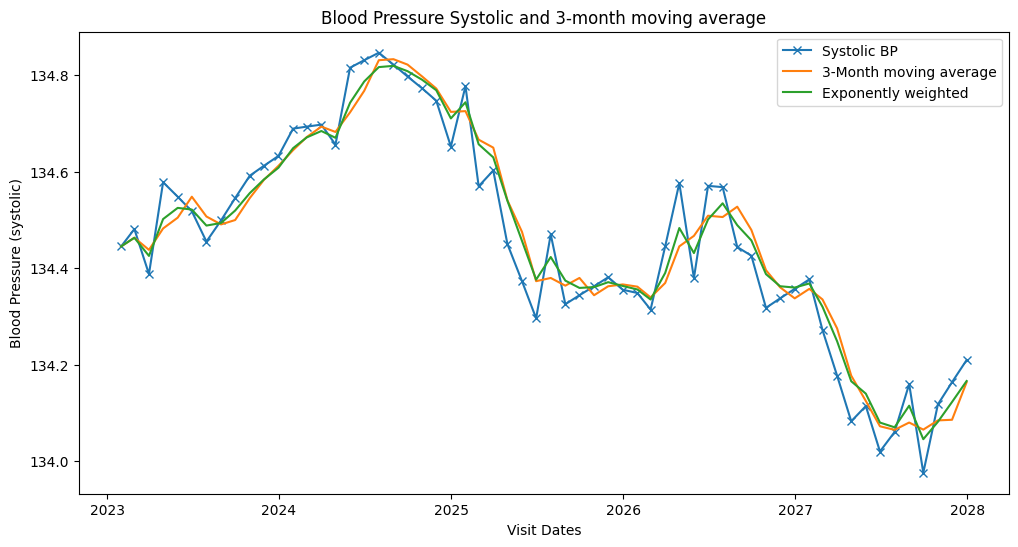

In [18]:
# Resample the data to monthly frequency using mean aggregation
bd_pressure = pd.Series(longitudinal_data_datetime["bp_systolic"].values, index = pd.to_datetime(longitudinal_data_datetime.index))

bd_pressure = bd_pressure.resample("ME").mean()
bd_pressure = bd_pressure.interpolate()  ## 중간에 연결이 안되서 넣어야 함. 
bd_pressure = bd_pressure.to_frame(name="bp_systolic")

# Calculate 3-month moving averages
bd_pressure["3-months_mv"] = bd_pressure.rolling(min_periods = 1, window = 3).mean()

# Calculate the exponently weighted moving average
bd_pressure["Exp_weighted"] = bd_pressure["bp_systolic"].ewm(span=3, adjust=False).mean()

# Visualize both the original and smoothed trends
plt.figure(figsize=(12,6))
plt.plot(bd_pressure.index, bd_pressure["bp_systolic"], label = "Systolic BP", marker = "x")
plt.plot(bd_pressure.index, bd_pressure["3-months_mv"], label = "3-Month moving average")
plt.plot(bd_pressure.index, bd_pressure["Exp_weighted"], label = "Exponently weighted")
plt.xlabel("Visit Dates")
plt.ylabel("Blood Pressure (systolic)")
plt.title("Blood Pressure Systolic and 3-month moving average")
plt.legend()
plt.show()


## Statistical Modeling Tasks

### 1. Analyze factors affecting baseline blood pressure

In [19]:
import statsmodels.api as sm

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     149.1
Date:                Tue, 05 Nov 2024   Prob (F-statistic):          6.36e-100
Time:                        23:30:14   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      1.979     54.812      0.0

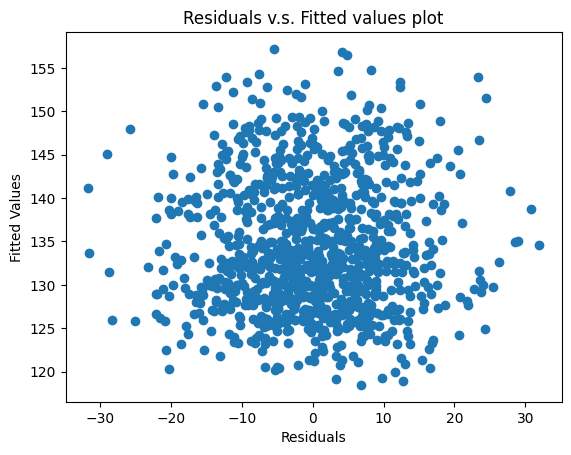

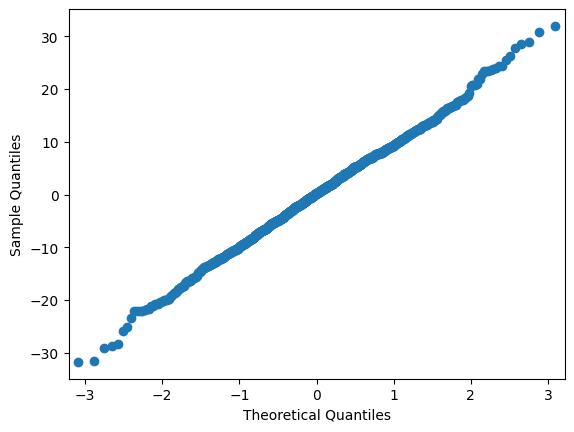

In [20]:
# Creating feature matrix x with predictors from baselne data
x = baseline_data[["age", "bmi", "smoking", "diabetes"]]
# Constant term added to the predictor matrix x
x = sm.add_constant(x)
y = baseline_data["bp_systolic"]

# Fit the OLS model
model_bdpressure = sm.OLS(y, x)
results_bdpressure = model_bdpressure.fit(cov_type="HC3")

# Examine the results of the model
print(results_bdpressure.summary())

# Residuals v.s. Fitted values plot
residuals = results_bdpressure.resid
fitted = results_bdpressure.fittedvalues

plt.scatter(residuals, fitted)
plt.xlabel("Residuals")
plt.ylabel("Fitted Values")
plt.title("Residuals v.s. Fitted values plot")

plt.show()

# QQ Plot 
sm.qqplot(data=results_bdpressure.resid)
plt.show()

### 2. Model treatment effectiveness

In [21]:
# Baseline characteristics and adherence are used as predictors for the model
x = treatment_data[["age", "sex", "bmi", "smoking", "diabetes", "bp_systolic", "cholesterol", "heart_rate", "adherence"]]
x = sm.add_constant(x)
y = treatment_data["outcome"]

# Fit a GLM model with binomial family to predict treatment success
model_treatment = sm.GLM(y, x, family=sm.families.Binomial())
results_treatment = model_treatment.fit()

# Examine the results of the model
print(results_treatment.summary())

# 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      990
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -652.91
Date:                Tue, 05 Nov 2024   Deviance:                       1305.8
Time:                        23:30:14   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02583
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.5227      1.249     -2.820      

In [22]:
# Calculate Odds ratio
print(f"Odds ratio is \n{np.exp(results_treatment.params)}")

# Calculate Confidence Intervals
conf_int = np.exp(results_treatment.conf_int())
conf_int.columns = ["2.5 %", "97.5 %"]

print(f"\nConfidence interval is \n {conf_int}")

Odds ratio is 
const          0.029521
age            0.996469
sex            0.892022
bmi            1.026068
smoking        0.597965
diabetes       0.564716
bp_systolic    1.008961
cholesterol    1.006952
heart_rate     1.001884
adherence      1.162271
dtype: float64

Confidence interval is 
                 2.5 %    97.5 %
const        0.002552  0.341510
age          0.985829  1.007224
sex          0.687935  1.156654
bmi          0.997521  1.055431
smoking      0.390961  0.914572
diabetes     0.393795  0.809823
bp_systolic  0.995734  1.022364
cholesterol  1.000515  1.013431
heart_rate   0.989644  1.014275
adherence    0.312541  4.322228


In [23]:
# Check for Residual deviance and Null deviance
print(f"Residual Deviance is {results_treatment.deviance}")
print(f"Null Deviance is {results_treatment.null_deviance}")

Residual Deviance is 1305.8118647624287
Null Deviance is 1331.9768185036032


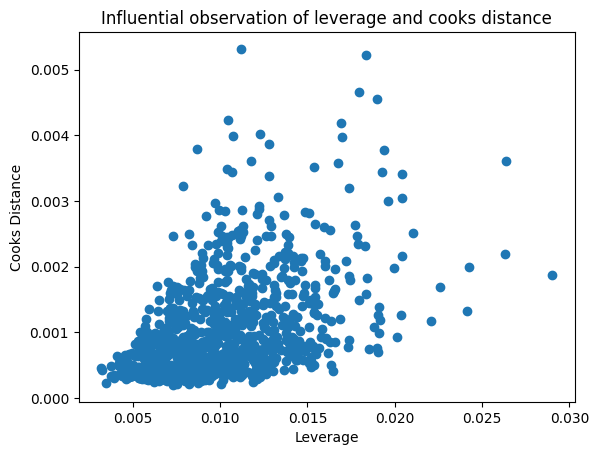

In [24]:
influence = results_treatment.get_influence()
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]

# Examine influential observations
plt.scatter(leverage, cooks)
plt.xlabel("Leverage")
plt.ylabel("Cooks Distance")
plt.title("Influential observation of leverage and cooks distance")

plt.show()

# Machine Learning Tasks (stretch goal)

### 1. Build prediction pipeline

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

# Baseline features
feature = baseline_data[["age", "bmi", "bp_systolic", "cholesterol", "heart_rate", "sex", "smoking", "diabetes"]]
features_num = baseline_data[["age", "bmi", "bp_systolic", "cholesterol", "heart_rate"]]
features_cat = baseline_data[["sex", "smoking", "diabetes"]]

outcome = treatment_data["outcome"]

# Preprocess pipeline - standardize numerical variables
preprocessor = ColumnTransformer(transformers=[("num", StandardScaler(), ["age", "bmi", "bp_systolic", "cholesterol", "heart_rate"]),
                                               ("cat", OneHotEncoder(), ["sex", "smoking", "diabetes"])])

# Create pipeline with specific components
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("selector", SelectKBest(score_func=f_classif, k=3)),
    ("classifier", LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, class_weight='balanced', C = 1.0))]
)

# Train model
pipeline.fit(feature, outcome)
outcome_predicted = pipeline.predict(feature)


### 2. Validate Model Performance

Classification metrix is 
              precision    recall  f1-score   support

           0       0.65      0.55      0.60       185
           1       0.42      0.53      0.47       115

    accuracy                           0.54       300
   macro avg       0.54      0.54      0.53       300
weighted avg       0.57      0.54      0.55       300

Confusion matrix is 
 [[102  83]
 [ 54  61]]
Area under the curve for ROC is 0.5408930669800235


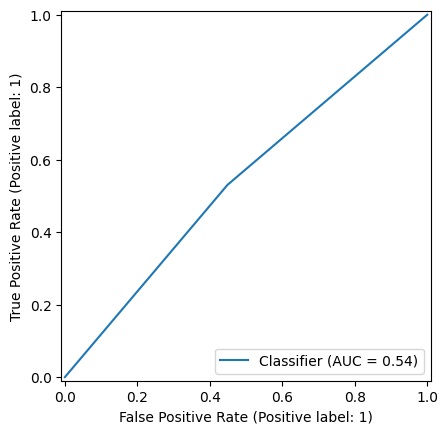

In [26]:
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold,
    cross_validate
)

from sklearn.metrics import (
    classification_report,
    RocCurveDisplay,
    roc_auc_score,
    confusion_matrix
)

# Split data into 70 % training and 30 % testing sets
X_train, X_test, y_train, y_test = train_test_split(feature, outcome, stratify = outcome, test_size=0.3, random_state=42)

# Cross-validation with multiple metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)

# Train model
pipeline.fit(X_train, y_train)
outcome_predicted = pipeline.predict(X_test)

# Classification metrices
print(f"Classification metrix is \n{classification_report(y_test, outcome_predicted)}")
print(f"Confusion matrix is \n {confusion_matrix(y_test, outcome_predicted)}")
print(f"Area under the curve for ROC is {roc_auc_score(y_test, outcome_predicted)}")

# ROC Curve
RocCurveDisplay.from_predictions(y_test, outcome_predicted)
plt.show()